# Cluster Analysis Based on MCI Original

In [184]:
'''
Import key packages
'''
import umap
from sklearn.manifold import TSNE
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
import scipy
from functools import reduce
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans


# debug mode (spits messages verbosely)
DEBUG = 0  # change it to 0 to switch it off

loc="../../../WES/Clinical Data/Raw/"
outdata="../../../WES/Clinical Data/Processed/"

config =dict(\
varsnormalise=['udprs_Disease_Progression','udprs_Age_Diagnosis','cog1_MMSE result',\
'udprs_non_tremor','udprs_tremor','udprs_tremor_ratio','cog1_NART','BDI_BDI Total'],\
nonnormvars=['cog1_Trails A Z score','Lm2_cut','ESS_norm','FOGQ_FOGQ 3','DDE_norm'],\
umap_neigbours=10,umap_comps=2,kmeans_try=10)

varsnormalise=config['varsnormalise']
nonnormvars=config['nonnormvars']


varsnormalise=['udprs_Disease_Progression','udprs_Age_Diagnosis','cog1_MMSE result',\
'udprs_tremor_ratio','cog1_NART','BDI_BDI Total']
nonnormvars=['cog1_Trails A Z score','Lm2_cut','ESS_norm','FOGQ_FOGQ 3','DDE_norm']

In [185]:
def z_score(col):
    x = (col - col.mean())/col.std(ddof=0)
    return  x

def takeonlyx_sd(df,x=5):

    for var in df.columns:
        if re.search('float|int',str(df[var].dtype)):
            maxvar=df[var].mean()+df[var].std()*5
            minvar=df[var].mean()-df[var].std()*5
            mask_rng=(df[var].between(minvar,maxvar))
            df[var][~mask_rng]=df[var][mask_rng].mean()
           # print(df[var].max())
           # print(df.shape)
    return df

def replacenullsmean(df,dropcols=['SYDID','Date of assessment','max_date']):
    usecols=[col for col in df.columns if col not in dropcols]
    df[usecols]=df[usecols].replace([np.inf, -np.inf], np.nan)
    for col in df[usecols].columns:
        nullmask=(df[col].isna())
        df[col][nullmask]=df[col][~nullmask].mean()
    return df

def umap_reducer(df,vars,neighb=10,comp=5):
    df_out=df.copy()
    
    for col in df_out.columns:
        if df_out[col].dtype!='object':
            df_out[col]=df_out[col].fillna(df_out[col][pd.notnull(df_out[col])].mean())
              
    dmod=df_out[[col for col in vars if col!='SYDID' and re.search('float',str(df_out[col].dtype))
                and df_out[col].count()>=df_out.shape[0]]]
    print(dmod.shape)
    
    reducer= umap.UMAP(n_neighbors=neighb,n_components=comp)
    reddata = pd.DataFrame(reducer.fit_transform(dmod)).reset_index()
    df_out=df_out.reset_index()
    print(reddata.shape)
    
    reddata.columns=['index','umap_var1','umap_var2']
    print(reddata)
    df_out[['umap_var1','umap_var2']]=reddata[['umap_var1','umap_var2']]
    return df_out

def tsne_reducer(df,vars,comp=5):
    df_out=df.copy()
    
    for col in df_out.columns:
        if df_out[col].dtype!='object':
            df_out[col]=df_out[col].fillna(df_out[col][pd.notnull(df_out[col])].mean())
              
    dmod=df_out[[col for col in vars if col!='SYDID' and re.search('float',str(df_out[col].dtype))
                and df_out[col].count()>=df_out.shape[0]]]
    print(dmod.shape)
    
    dod_embedded = pd.DataFrame(TSNE(n_components=2).fit_transform(dmod)).reset_index()

    print(dod_embedded.shape)
    df_out=df_out.reset_index()
    
    dod_embedded.columns=['index','tsne_var1','tsne_var2']
    df_out[['index','tsne_var1','tsne_var2']]=dod_embedded[['index','tsne_var1','tsne_var2']]
    return df_out



def elbow_clust(df,clustrange=10,clustfit=4,dropvars=['SYDID','Date of assessment','max_date']):
    df_vars=df.drop(columns=dropvars)
    dv2=[col for col in df_vars if df_vars[col].dtype=='float32']
    print(dv2)
    df_vars=df_vars[dv2]
    print(df_vars.columns)
    df_vars=replacenullsmean(df_vars)
    
    wcss=[]
    #print(df_vars.head())
    for i in range(1,clustrange): 
         kmeans = KMeans(n_clusters=i, init ='k-means++', max_iter=300,  n_init=clustrange-1,random_state=0)
         kmeans.fit(df_vars)
         wcss.append(kmeans.inertia_)
    plt.plot(range(1,clustrange),wcss)
    plt.title('The Elbow Method Graph')
    plt.xlabel('Number of clusters')
    plt.ylabel('WCSS')
    plt.show()
    kmeans = KMeans(n_clusters=clustfit, random_state=0).fit(df_vars)
    df['cluster_label']=kmeans.labels_.tolist()
    return df

def findcols(df,string):
    return [col for col in df.columns if re.search(string,col)]

In [186]:
PDcombined=pd.read_csv('%s%s' % (outdata,'PDcombined.csv'))

In [187]:
PDcombined['SYDID'].value_counts()

PD_00414_JM    5
PD_00025_SM    4
PD_00004_AW    4
PD_00133_CT    4
PD_00196_JD    3
              ..
PD_00583_KC    1
PD_00001_DA    1
PD_00048_PH    1
PD_00494_RG    1
PD_00496_JB    1
Name: SYDID, Length: 152, dtype: int64

In [188]:
longvars=['udprs_SectionIIITotal_coef','cog1_MMSEresult_coef','udprs_UDPRS_Tot_coef']

#### Data Processing

In [189]:
mask_BDI_miss=(PDcombined['BDI_BDI Total']>200)

In [190]:
PDcombined=PDcombined[~(mask_BDI_miss)]

In [191]:

logmem2cutoff=PDcombined['cog1_Logical Memory II'].mean()+PDcombined['cog1_Logical Memory II'].std()*1.5
masklm2=(PDcombined['cog1_Logical Memory II']<logmem2cutoff)

PDcombined['Lm2_cut']=0
PDcombined['Lm2_cut'][(masklm2)]=1

mask0=(PDcombined['udprs_DDE']>0)
masklt1000=(PDcombined['udprs_DDE']<1000)
PDcombined['DDE_norm']=0
PDcombined['DDE_norm'][mask0&masklt1000]=1
PDcombined['DDE_norm'][mask0&~masklt1000]=2

maskbdi=(PDcombined['BDI_BDI Total']>13)
PDcombined['BDI_norm']=0
PDcombined['BDI_norm'][maskbdi]=1

maskess=(PDcombined['ESS_ESS Total']>10)
PDcombined['ESS_norm']=0
PDcombined['ESS_norm'][maskess]=1

mask_ratio=((PDcombined['udprs_tremor_ratio']==np.inf))
PDcombined['udprs_tremor_ratio'][mask_ratio]=PDcombined['udprs_tremor_ratio'][~mask_ratio].mean()

for col in varsnormalise:
    nullmask=(PDcombined[col].isna())
    PDcombined[col][nullmask]=PDcombined[col][~nullmask].mean()
    PDcombined[col+'_z_score']=z_score(PDcombined[col])
vars_z=[var +'_z_score' for var in varsnormalise ]
varscluster=np.append(['SYDID','Date of assessment'],nonnormvars)
varscluster=np.append(varscluster,vars_z)

'''
Substitute to only have max date
'''
PDcombined['max_date']=PDcombined.groupby('SYDID')['Date of assessment'].transform(max)

mask_date_max=(PDcombined['max_date']==PDcombined['Date of assessment'])
PDcombined_sub=PDcombined[mask_date_max]

'''
Removal of columns that don't work
'''

othcols=[col for col in PDcombined.columns if (PDcombined[col].dtype!='object'\
and col not in varscluster) or col in ['SYDID','Date of assessment','udprs_Disease_Progression',\
'udprs_Age_Diagnosis']]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path(

In [192]:
PDcluster_alt=PDcombined_sub[othcols]
PDcluster=PDcombined_sub[varscluster]

for var in PDcluster.columns:
    PDcluster=PDcluster[(PDcluster[var]!=999)]
    
PDcluster_alt=takeonlyx_sd(df=PDcluster_alt,x=3)
PDcluster_alt=replacenullsmean(PDcluster_alt)

'''
Reduce using umap
'''

pdclust_umap=umap_reducer(PDcluster_alt,PDcluster_alt.columns,\
neighb=config['umap_neigbours'],comp=config['umap_comps'])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/opt/conda/lib/python3.7/site-packages/pandas/core/generic.py:9114: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/opt/conda/lib/python3.7/site-packages/pand

(151, 344)
(151, 3)
     index  umap_var1  umap_var2
0        0   3.295529   1.674838
1        1   4.470050   4.261140
2        2   1.692238   1.345176
3        3   1.881924   1.435059
4        4  -9.096156 -11.762888
..     ...        ...        ...
146    146   4.330895  -6.738398
147    147   3.809952  -8.940137
148    148   3.689993   2.663993
149    149   3.730044  -9.005669
150    150   4.462279  -6.998035

[151 rows x 3 columns]


In [204]:
def cluster_output(df=PDcluster,reps=10):
    
    df_new=pd.DataFrame([]) 
    df_out=takeonlyx_sd(df,x=3)
    df_out=replacenullsmean(df_out)
    
    for i in range(reps):
    
        pdclust_umap=umap_reducer(df_out,varscluster,\
        neighb=2,comp=config['umap_comps'])

        PDcluster_clust=elbow_clust(pdclust_umap[['SYDID','Date of assessment','umap_var1','umap_var2']],\
        clustfit=3,dropvars=['SYDID','Date of assessment'])
        
        df1=PDcluster_clust[['SYDID','cluster_label']]
        df1['rep']=i
        
        df_new=
        
    return df_new
        
        
        



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 34 separate connected components using meta-embedding (experimental)
  n_components


(150, 8)
(150, 3)
     index  umap_var1  umap_var2
0        0   1.283975   2.637699
1        1   8.449777   1.080295
2        2  -5.547128 -10.697483
3        3   2.431186  10.619600
4        4  -4.278057  -0.484225
..     ...        ...        ...
145    145  -8.192678  -3.815367
146    146   0.464466   2.703924
147    147   1.236070   2.661740
148    148   0.017049  16.084457
149    149   6.654678   9.930830

[150 rows x 3 columns]
['umap_var1', 'umap_var2']
Index(['umap_var1', 'umap_var2'], dtype='object')


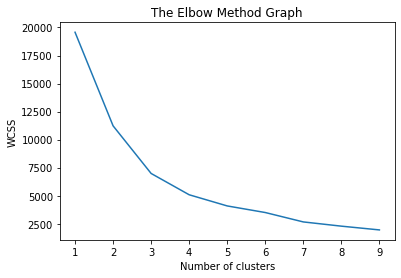

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 34 separate connected components using meta-embedding (experimental)
  n_components


           SYDID Date of assessment  umap_var1  umap_var2  cluster_label
0    PD_00001_DA         2013-05-28   1.283975   2.637699              0
1    PD_00002_MW         2011-10-25   8.449777   1.080295              2
2    PD_00004_AW         2014-07-21  -5.547128 -10.697483              0
3    PD_00008_BM         2014-11-03   2.431186  10.619600              1
4    PD_00017_RE         2011-08-23  -4.278057  -0.484225              0
..           ...                ...        ...        ...            ...
145  PD_00553_KM         2012-10-16  -8.192678  -3.815367              0
146  PD_00555_PH         2012-11-20   0.464466   2.703924              0
147  PD_00557_DC         2012-11-06   1.236070   2.661740              0
148  PD_00568_MB         2012-11-27   0.017049  16.084457              1
149  PD_00583_KC         2013-03-19   6.654678   9.930830              2

[150 rows x 5 columns]
(150, 8)
(150, 3)
     index  umap_var1  umap_var2
0        0 -14.582335   3.677864
1        1   6.6

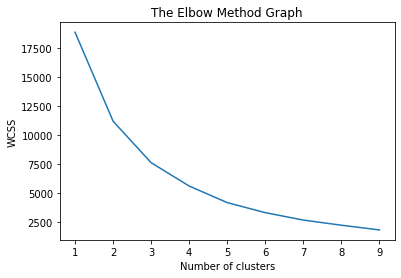

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 34 separate connected components using meta-embedding (experimental)
  n_components


           SYDID Date of assessment  umap_var1  umap_var2  cluster_label
0    PD_00001_DA         2013-05-28 -14.582335   3.677864              1
1    PD_00002_MW         2011-10-25   6.642049   3.505375              0
2    PD_00004_AW         2014-07-21   1.290823  -4.604040              2
3    PD_00008_BM         2014-11-03 -16.973322  -2.065593              1
4    PD_00017_RE         2011-08-23   2.252930   7.574164              0
..           ...                ...        ...        ...            ...
145  PD_00553_KM         2012-10-16   4.695230  -0.259703              0
146  PD_00555_PH         2012-11-20 -14.405867   4.091614              1
147  PD_00557_DC         2012-11-06 -14.620639   3.732882              1
148  PD_00568_MB         2012-11-27  -4.195709  -0.301222              2
149  PD_00583_KC         2013-03-19  -5.563758   2.909901              1

[150 rows x 5 columns]
(150, 8)
(150, 3)
     index  umap_var1  umap_var2
0        0  -7.986809  17.855829
1        1  12.7

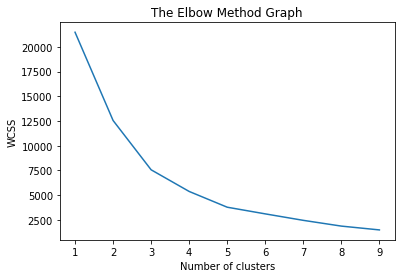

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 34 separate connected components using meta-embedding (experimental)
  n_components


           SYDID Date of assessment  umap_var1  umap_var2  cluster_label
0    PD_00001_DA         2013-05-28  -7.986809  17.855829              2
1    PD_00002_MW         2011-10-25  12.774016   7.829551              1
2    PD_00004_AW         2014-07-21   1.871368  -9.122353              0
3    PD_00008_BM         2014-11-03  -7.508816  -3.291780              0
4    PD_00017_RE         2011-08-23   5.597550  -1.693084              1
..           ...                ...        ...        ...            ...
145  PD_00553_KM         2012-10-16  -5.186437 -12.021468              0
146  PD_00555_PH         2012-11-20  -8.525873  17.806534              2
147  PD_00557_DC         2012-11-06  -7.958020  17.907820              2
148  PD_00568_MB         2012-11-27   0.233553   5.132957              1
149  PD_00583_KC         2013-03-19  -8.193950   6.148604              2

[150 rows x 5 columns]
(150, 8)
(150, 3)
     index  umap_var1  umap_var2
0        0 -13.822474   4.818149
1        1   2.4

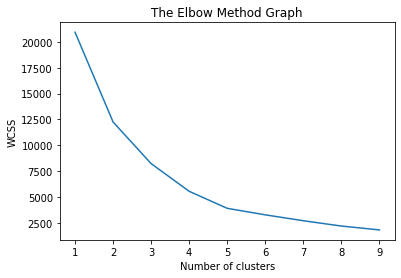

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 34 separate connected components using meta-embedding (experimental)
  n_components


           SYDID Date of assessment  umap_var1  umap_var2  cluster_label
0    PD_00001_DA         2013-05-28 -13.822474   4.818149              0
1    PD_00002_MW         2011-10-25   2.408672   2.166487              1
2    PD_00004_AW         2014-07-21  -3.569541 -14.041936              0
3    PD_00008_BM         2014-11-03  -4.427933 -16.831661              0
4    PD_00017_RE         2011-08-23  -1.379314   1.730816              0
..           ...                ...        ...        ...            ...
145  PD_00553_KM         2012-10-16 -10.103013  -1.605339              0
146  PD_00555_PH         2012-11-20 -13.337544   5.493124              0
147  PD_00557_DC         2012-11-06 -13.719687   4.922126              0
148  PD_00568_MB         2012-11-27  -7.325602   2.142550              0
149  PD_00583_KC         2013-03-19  12.096390  11.745039              1

[150 rows x 5 columns]
(150, 8)
(150, 3)
     index  umap_var1  umap_var2
0        0  -4.412511   7.801097
1        1   8.6

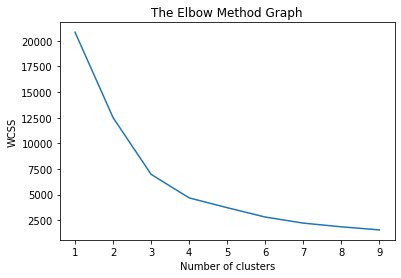

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 34 separate connected components using meta-embedding (experimental)
  n_components


           SYDID Date of assessment  umap_var1  umap_var2  cluster_label
0    PD_00001_DA         2013-05-28  -4.412511   7.801097              2
1    PD_00002_MW         2011-10-25   8.683707  12.156887              1
2    PD_00004_AW         2014-07-21  -4.986621 -12.464462              0
3    PD_00008_BM         2014-11-03 -10.973873   3.136297              2
4    PD_00017_RE         2011-08-23   8.667702   6.150021              1
..           ...                ...        ...        ...            ...
145  PD_00553_KM         2012-10-16  -5.929264  -7.335020              0
146  PD_00555_PH         2012-11-20  -4.462156   8.352159              2
147  PD_00557_DC         2012-11-06  -4.505142   7.890235              2
148  PD_00568_MB         2012-11-27 -12.951875   0.902035              2
149  PD_00583_KC         2013-03-19  -5.515443   2.403278              2

[150 rows x 5 columns]
(150, 8)
(150, 3)
     index  umap_var1  umap_var2
0        0   4.039943  11.547999
1        1   9.2

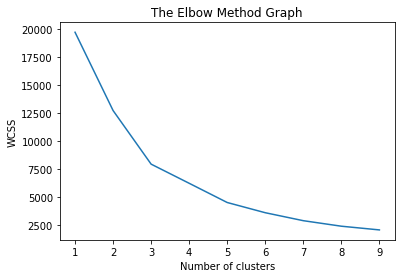

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 34 separate connected components using meta-embedding (experimental)
  n_components


           SYDID Date of assessment  umap_var1  umap_var2  cluster_label
0    PD_00001_DA         2013-05-28   4.039943  11.547999              2
1    PD_00002_MW         2011-10-25   9.291625   9.316917              2
2    PD_00004_AW         2014-07-21  -2.846049  -4.774906              0
3    PD_00008_BM         2014-11-03 -16.706190   1.128096              1
4    PD_00017_RE         2011-08-23   3.360425  -3.269425              0
..           ...                ...        ...        ...            ...
145  PD_00553_KM         2012-10-16  -0.398917   0.967958              0
146  PD_00555_PH         2012-11-20   4.573127  11.187982              2
147  PD_00557_DC         2012-11-06   4.023367  11.535436              2
148  PD_00568_MB         2012-11-27  -1.995775  10.434828              1
149  PD_00583_KC         2013-03-19   1.389478   8.421453              2

[150 rows x 5 columns]
(150, 8)
(150, 3)
     index  umap_var1  umap_var2
0        0  -4.733392   7.342729
1        1   6.1

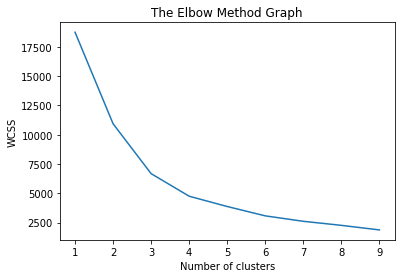

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 34 separate connected components using meta-embedding (experimental)
  n_components


           SYDID Date of assessment  umap_var1  umap_var2  cluster_label
0    PD_00001_DA         2013-05-28  -4.733392   7.342729              1
1    PD_00002_MW         2011-10-25   6.188507   8.288023              0
2    PD_00004_AW         2014-07-21  -4.779830  -4.187297              2
3    PD_00008_BM         2014-11-03 -14.577182  -0.694883              2
4    PD_00017_RE         2011-08-23   0.346652  12.109157              1
..           ...                ...        ...        ...            ...
145  PD_00553_KM         2012-10-16 -11.274733   6.981408              1
146  PD_00555_PH         2012-11-20  -3.928364   7.414135              1
147  PD_00557_DC         2012-11-06  -4.701437   7.387313              1
148  PD_00568_MB         2012-11-27  -7.435274 -10.601989              2
149  PD_00583_KC         2013-03-19   9.584459   3.607764              0

[150 rows x 5 columns]
(150, 8)
(150, 3)
     index  umap_var1  umap_var2
0        0   8.407514   8.927063
1        1  12.1

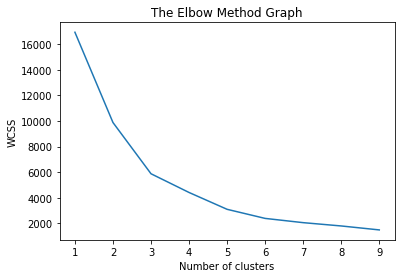

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 34 separate connected components using meta-embedding (experimental)
  n_components


           SYDID Date of assessment  umap_var1  umap_var2  cluster_label
0    PD_00001_DA         2013-05-28   8.407514   8.927063              2
1    PD_00002_MW         2011-10-25  12.103194   9.250566              2
2    PD_00004_AW         2014-07-21  -1.223731 -11.356659              0
3    PD_00008_BM         2014-11-03  -8.239883  -3.020365              1
4    PD_00017_RE         2011-08-23   5.410343   0.849021              2
..           ...                ...        ...        ...            ...
145  PD_00553_KM         2012-10-16 -10.003391  -7.483078              1
146  PD_00555_PH         2012-11-20   8.756505   9.403149              2
147  PD_00557_DC         2012-11-06   8.434215   8.913634              2
148  PD_00568_MB         2012-11-27 -12.691311   5.468179              1
149  PD_00583_KC         2013-03-19  -5.254969   3.432001              1

[150 rows x 5 columns]
(150, 8)
(150, 3)
     index  umap_var1  umap_var2
0        0  -4.068532   4.047334
1        1  14.0

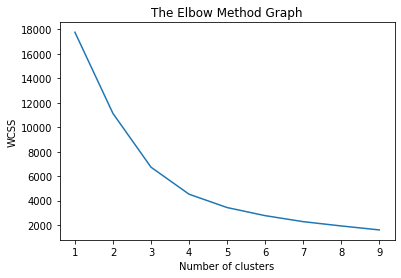

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 34 separate connected components using meta-embedding (experimental)
  n_components


           SYDID Date of assessment  umap_var1  umap_var2  cluster_label
0    PD_00001_DA         2013-05-28  -4.068532   4.047334              1
1    PD_00002_MW         2011-10-25  14.049716   0.250024              2
2    PD_00004_AW         2014-07-21   2.266686 -12.202632              0
3    PD_00008_BM         2014-11-03   3.421606   6.562604              2
4    PD_00017_RE         2011-08-23   8.902031  -4.988071              0
..           ...                ...        ...        ...            ...
145  PD_00553_KM         2012-10-16  -1.268665  -0.786910              0
146  PD_00555_PH         2012-11-20  -3.404041   4.240371              1
147  PD_00557_DC         2012-11-06  -3.959254   4.005673              1
148  PD_00568_MB         2012-11-27  -8.316870  10.404629              1
149  PD_00583_KC         2013-03-19   1.752287  12.735206              2

[150 rows x 5 columns]
(150, 8)
(150, 3)
     index  umap_var1  umap_var2
0        0  -9.231977   5.171607
1        1   8.0

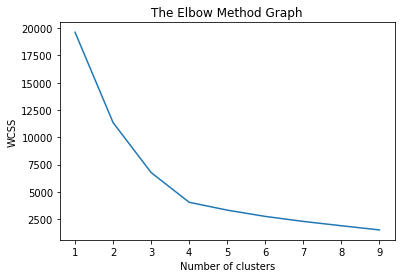

           SYDID Date of assessment  umap_var1  umap_var2  cluster_label
0    PD_00001_DA         2013-05-28  -9.231977   5.171607              0
1    PD_00002_MW         2011-10-25   8.020840  13.638159              2
2    PD_00004_AW         2014-07-21  -3.294166 -10.090461              1
3    PD_00008_BM         2014-11-03  -2.878000  -6.604627              1
4    PD_00017_RE         2011-08-23   9.588014   0.268448              2
..           ...                ...        ...        ...            ...
145  PD_00553_KM         2012-10-16   0.115979 -14.360480              1
146  PD_00555_PH         2012-11-20  -9.758817   5.155267              0
147  PD_00557_DC         2012-11-06  -9.284993   5.142805              0
148  PD_00568_MB         2012-11-27   2.059097  -3.958671              1
149  PD_00583_KC         2013-03-19   5.290011  10.222938              2

[150 rows x 5 columns]


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [205]:
cluster_output()

In [193]:
#pdclust_tsne=tsne_reducer(PDcluster,varscluster,2)

In [194]:
PDcluster=takeonlyx_sd(df=PDcluster,x=3)
PDcluster=replacenullsmean(PDcluster)

pdclust_umap=umap_reducer(PDcluster,varscluster,\
neighb=2,comp=config['umap_comps'])

(150, 8)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/umap/spectral.py:229: UserWa

(150, 3)
     index  umap_var1  umap_var2
0        0  -0.411061   2.071773
1        1   8.349899   7.603102
2        2  -8.136537 -11.370152
3        3  -3.107959  -9.946385
4        4   6.757675   8.638041
..     ...        ...        ...
145    145   0.871761  -3.673747
146    146  -0.466330   2.603683
147    147  -0.388951   2.044470
148    148  -6.782938   8.854002
149    149   4.664352  13.575341

[150 rows x 3 columns]


In [195]:
pdclust_umap=umap_reducer(PDcluster,PDcluster.columns,neighb=10,comp=2)

(150, 8)
(150, 3)
     index  umap_var1  umap_var2
0        0   2.800707   0.949076
1        1   1.131264  -0.898016
2        2   0.061022   3.124319
3        3   2.206969   4.282503
4        4   1.986599   0.699516
..     ...        ...        ...
145    145   1.885683   1.478881
146    146   2.850404   0.159183
147    147   2.590519   0.918364
148    148   1.639149   2.886956
149    149   0.272416   1.319296

[150 rows x 3 columns]


['umap_var1', 'umap_var2']
Index(['umap_var1', 'umap_var2'], dtype='object')


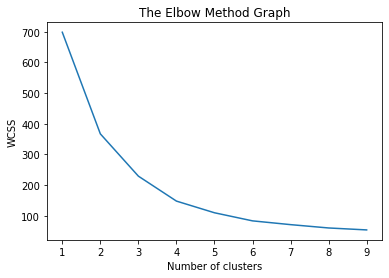

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


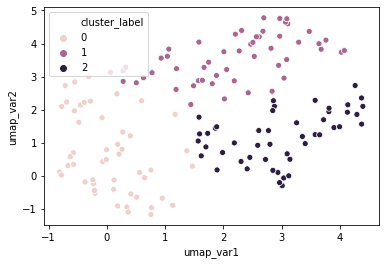

In [196]:
PDcluster_clust=elbow_clust(pdclust_umap[['SYDID','Date of assessment','umap_var1','umap_var2']],\
clustfit=3,dropvars=['SYDID','Date of assessment'])

sns.scatterplot(data=PDcluster_clust, x="umap_var1", y="umap_var2",hue='cluster_label')


In [197]:
mask1=(PDcombined['Date of assessment']==PDcombined['max_date'])

print(PDcombined.shape)
print(PDcluster_clust.shape)

varsused=['SYDID','Date of assessment','udprs_Disease_Progression','udprs_Age_Diagnosis','BDI_BDI Total','cog1_MMSE result',\
'udprs_non_tremor','udprs_tremor','udprs_tremor_ratio','cog1_NART','DDE_norm']

mask=(pd.notnull(PDcluster_clust['SYDID'])&pd.notnull(PDcluster_clust['Date of assessment']))
mask2=(pd.notnull(PDcombined['SYDID'])&pd.notnull(PDcombined['Date of assessment']))


(252, 555)
(150, 5)


In [198]:
PDcluster_clust_new=PDcluster_clust[['SYDID','Date of assessment','cluster_label']][mask]
PDcombined_new=PDcombined[varsused][mask2&mask1]

In [199]:
PDcombined_new.shape

(151, 11)

In [200]:


PDcluster_clust_new['Date of assessment']=pd.to_datetime(PDcluster_clust_new['Date of assessment'])
PDcombined_new['Date of assessment']=pd.to_datetime(PDcombined_new['Date of assessment'])

print(PDcluster_clust_new.shape)
print(PDcombined_new.shape)

clust=pd.merge(PDcombined_new,PDcluster_clust_new,on=['SYDID','Date of assessment'],how='inner')
print(clust.shape)

(150, 3)
(151, 11)
(150, 12)


In [201]:


print(clust.shape)

clust_gp_mean=pd.DataFrame(clust.groupby(['cluster_label'])['udprs_Disease_Progression','udprs_Age_Diagnosis','cog1_MMSE result',\
 'udprs_non_tremor','udprs_tremor','udprs_tremor_ratio','cog1_NART','BDI_BDI Total'].mean()).reset_index()

clust_gp_size=pd.DataFrame(clust.groupby(['cluster_label']).size()).reset_index()
clust_gp_size.columns=['cluster_label','num_patients']

clust_gp_mean=pd.merge(clust_gp_mean,clust_gp_size,on='cluster_label',how='inner')
clust_gp_mean

(150, 12)


,cluster_label,udprs_Disease_Progression,udprs_Age_Diagnosis,cog1_MMSE result,udprs_non_tremor,udprs_tremor,udprs_tremor_ratio,cog1_NART,BDI_BDI Total,num_patients
0,0,0.020592,53.678750,29.000000,1.473469,0.265306,0.199586,110.567918,9.918367,49
1,1,0.198995,62.524402,29.490566,1.122642,0.743396,0.721468,113.921283,6.754717,53
2,2,0.036279,62.912446,27.145833,1.300000,0.566667,0.483700,105.041667,10.187500,48


In [168]:
PDcombined['Date of assessment']=pd.to_datetime(PDcombined['Date of assessment'])

PDCombined_clust=pd.merge(PDcombined,PDcluster_clust_new,on=['SYDID','Date of assessment'],how='inner')


In [169]:
PDCombined_clust_long=pd.merge(PDcombined,PDCombined_clust[['SYDID','cluster_label','Group']],on='SYDID',how='left')

In [170]:
PDCombined_clust_long.to_csv('%s%s' % (outdata,'PDCombined_clust_long.csv'))

In [171]:
PDCombined_clust.to_csv('%s%s' % (outdata,'PDCombined_clust.csv'))

In [109]:
PDCombined_clust.groupby(['cluster_label','Group']).size()

cluster_label  Group
0              1.0      16
               2.0       5
               3.0       6
1              1.0       8
               2.0       1
               3.0       4
               4.0       2
2              1.0      10
               2.0       2
               3.0       8
               4.0       2
3              1.0      20
               2.0       7
               3.0       1
               4.0      14
dtype: int64

In [23]:
mask_gp=pd.notnull(PDCombined_clust['Group'])
PDCombined_clust[mask_gp].shape

(106, 556)